In [2]:
def load(directory, option):
    if option.lower() == 'raw data':
        dirname = "/RawData/"
        extension = ".csv"

    files_list = [f for f in os.listdir(directory + dirname) if f.lower().endswith(extension)]
    list_objects = []
    for file in files_list:
        path = directory + dirname + file
        an_object = np.genfromtxt(path, delimiter=",")
        list_objects.extend(an_object)
    # return a list[Array_TimeSeries]
    return list_objects

In [83]:
def dot_products_1(q, t):
    m, n = len(q), len(t)
    t_a = np.concatenate([t, np.zeros(n)])
    # reverse the Query
    q_r = q[::-1]
    q_ra = np.concatenate([q_r, np.zeros(2 * n - m)])
    q_raf = np.fft.fft(q_ra)
    t_af = np.fft.fft(t_a)
    qt = np.fft.ifft(q_raf * t_af)
    return qt
    
def dot_products_2(q, t):
    # concatenante n-m zeros for Query
    m, n = len(q), len(t)
    # reverse the Query
    q_r = q[::-1]
    q_ra = np.concatenate([q_r, np.zeros(n - m)])
    q_raf = np.fft.fft(q_ra)
    t_af = np.fft.fft(t)
    qt = np.fft.ifft(q_raf * t_af)
    return qt

def mass_v1(q, t):
    m, n = len(q), len(t)
    # Z-normalization of Query
    q = (q-np.mean(q)) / np.std(q)
    
    qt = dot_products_1(q, t)
    #compute the mean and standard deviation of Time Series
    sum_q = np.sum(q)
    sum_q2 = np.sum(np.power(q,2))

    #cache a cumulative sum of values
    cum_sum_t = np.cumsum(t)
    cum_sum_t2 = np.cumsum(np.power(t,2))
    #71
    sumt = cum_sum_t[m-1:] - np.concatenate([[0], cum_sum_t[:n-m]])
    sumt2 = cum_sum_t2[m-1:] - np.concatenate([[0], cum_sum_t2[:n-m]])
    meant = sumt / m
    #standard deviation of every subsequence of length m
    sigmat2 = (sumt2 / m) - (np.power(meant,2))
    sigmat = np.sqrt(sigmat2)
    
    dist = (sumt2 - 2 * sumt * meant + m * (np.power(meant,2))) / sigmat2 - 2 * (qt[m-1:n] - sum_q * meant) / sigmat + sum_q2
    dist = np.sqrt(dist)
    #distance here is a complex number, need to return its amplitude/absolute value
    #return a vector with size of n-m+1
    return np.abs(dist)

def mass_v2(x, y):
    #x is the data, y is the query
    n, m = len(x), len(y)

    #%compute y stats -- O(n)
    meany = np.mean(y)

    sigmay = np.std(y)
    #compute x stats -- O(n)
    #compute the average of the first m elements in 'x'
    def running_mean(x, N):
        cumsum = np.cumsum(np.insert(x, 0, np.zeros(N)))
        return (cumsum[N:] - cumsum[:-N]) / float(N)

    def running_std(x, N):
        x2 = np.power(x, 2)
        cumsum2 = np.cumsum(np.insert(x2, 0, np.zeros(N)))
        return ((cumsum2[N:] - cumsum2[:-N]) / float(N) - running_mean(x, N) ** 2) ** 0.5

    #compute the moving average and standard deviation of Time Series
    meanx = running_mean(x,m)
    sigmax = running_std(x,m)
   
    #The main trick of getting dot products in O(n log n) time
    z = dot_products_2(y, x)
    #dist = 2 * (m - (z[m-1:n] - m * meanx[m-1:n] * meany) / (sigmax[m-1:n] * sigmay))
    dist = 2 * (m - (z[m-1:n] - m * meanx[m-1:n] * meany) / (sigmax[m-1:n] * sigmay))
    dist = np.sqrt(dist)
    #distance here is a complex number, need to return its amplitude/absolute value
    #return a vector with size of n-m+1
    return np.abs(dist)

def computeMP(timeseries1, timeseries2, subseq_length):
    #timeseries1: Query TS, timeseries2: Target TS
    t1 = timeseries1
    t2 = timeseries2
    n1 = len(timeseries1)
    n2 = len(timeseries2)
    indexes = n1 - subseq_length + 1
    MP12 = [] #Matrix Profile
    #IP12 = [0] #Index Profile
    DP_all = {} # Distance Profiles for All Index in the timeseries
    idx = 0
    if int(subseq_length/4)==0:
        step = 1
    else:
        step = int(subseq_length / 4)
    step = 1
    for index in range(0, indexes, step):
        data = t2
        index2 = index + subseq_length
        #query = t2.timeseries[index:index2]
        query = t1[index:index2]
        # compute Distance Profile(DP)
        #DP = mass_v2(data, query)
        # if std(query)==0, then 'mass_v2' will return a NAN, ignore this Distance profile
        #Numpy will generate the result with datatype 'float64', where std(query) maybe equals to 'x*e-17', but not 0
        if round(np.std(query),4) == 0:
            continue
        else:
            #DP_all[idx] = mass_v1(query,data)
            DP_all[idx] = mass_v2(data, query)
            MP12.append(min(DP_all[idx]))
            idx += 1
    return DP_all, MP12


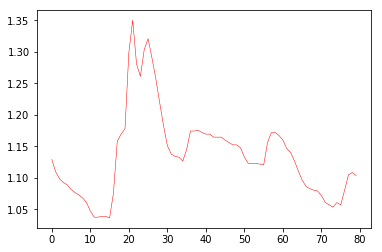

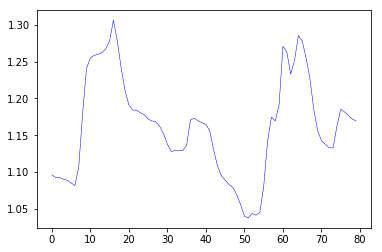

In [84]:
import pandas as pd
Insect = np.genfromtxt("/Users/Jingwei/Downloads/VALMOD_data/Insect.csv")
#nbr_point = len(ECG_data)

nbr_point = 80
plt.figure()
X = range(0, nbr_point)
data1 = Insect[0:nbr_point]
plt.plot(X, data1, color='red', linewidth=0.5)
plt.savefig("/Users/Jingwei/Desktop/MP_datasource1.eps")
plt.figure()
X = range(0, nbr_point)
data2 = Insect[nbr_point:2*nbr_point]
plt.plot(X, data2, color='blue', linewidth=0.5)
plt.savefig("/Users/Jingwei/Desktop/MP_datasource2.eps")




MP_array is  [0.3776004361036538, 0.422642512389877, 0.4437085029908621, 0.3476860146305869, 0.2621349290171666, 0.2408060906612392, 0.38951487053215866, 0.5173967257925935, 0.5215608001381331, 0.4246335412450899, 0.3458176290860462, 0.8951505328835802, 0.7770425941640358, 0.8635014801887008, 0.9175393868785537, 0.8402519508589291, 0.9469447608040026, 1.1108482398008646, 1.3026436134544863, 1.6106129852645252, 1.377107270258078, 1.0939845303167792, 0.6819724050658087, 0.5576958024004179, 0.4576207025738986, 0.3985526664943573, 0.3301937533992428, 0.4004122608626929, 0.4938208265132904, 0.7317666223575088, 0.7067434964921849, 0.5344863704082398, 0.6569233344549524, 1.0983036990131811, 1.6480365042398482, 2.687239208607812, 0.9528520621636122, 0.7191543162095794, 0.6754221606826782, 0.5525289598459335, 0.6481100617254265, 0.6007660335299488, 0.39905371933789063, 0.4283870618040394, 0.42091059292373284, 0.42337200707894085, 0.4936313936089011, 0.5697631215762681, 0.7987811707734497, 0.815

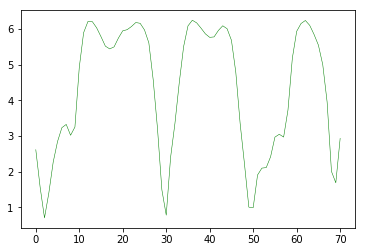

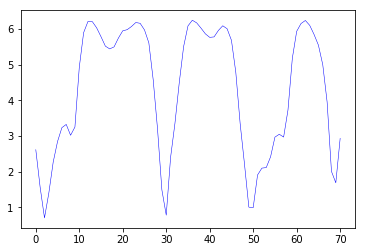

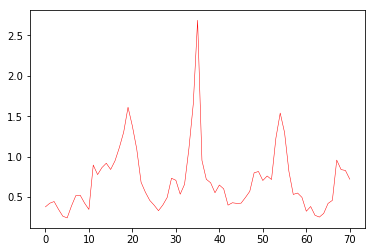

In [85]:
window = 10
Query = data1[50:60]
DP_array_1 = mass_v1(Query,data2)
plt.figure()
X = range(0, len(DP_array_1))
plt.plot(X, DP_array_1, color='green', linewidth=0.5)
#plt.savefig("/Users/Jingwei/Desktop/DistanceProfile.eps")

DP_array_2 = mass_v2(data2,Query)
plt.figure()
X = range(0, len(DP_array_2))
plt.plot(X, DP_array_2, color='blue', linewidth=0.5)

plt.figure()
DP, MP_array = computeMP(data1,data2,10)
X = range(0, len(MP_array))
print ("MP_array is ", MP_array)
plt.plot(X, MP_array, color='red', linewidth=0.5)
plt.savefig("/Users/Jingwei/Desktop/MatrixProfile.eps")



/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


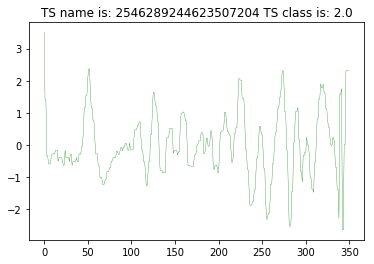

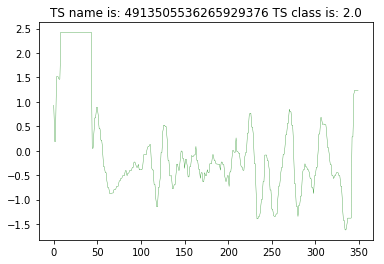

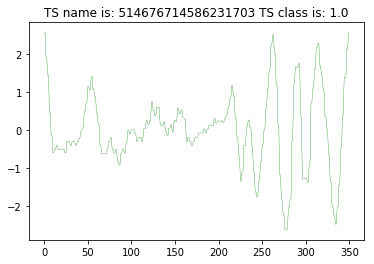

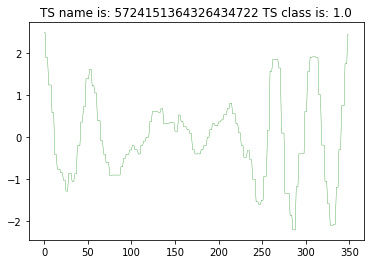

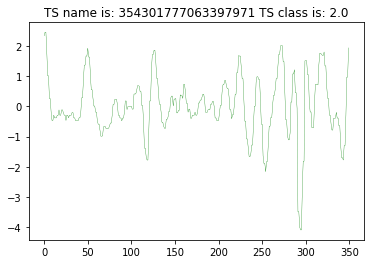

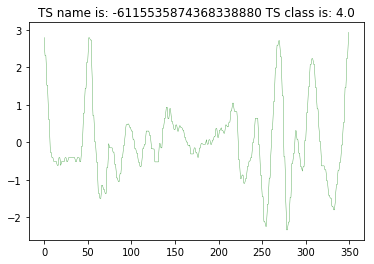

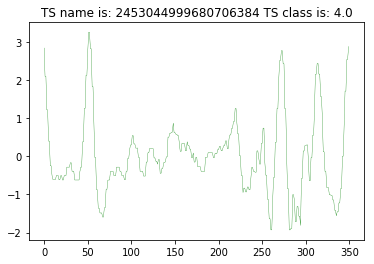

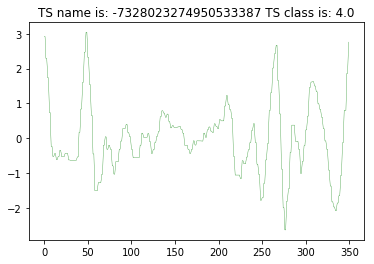

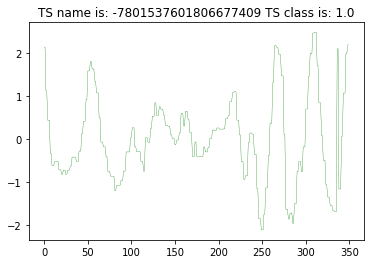

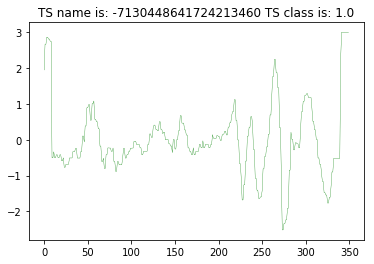

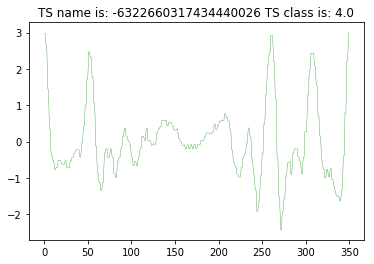

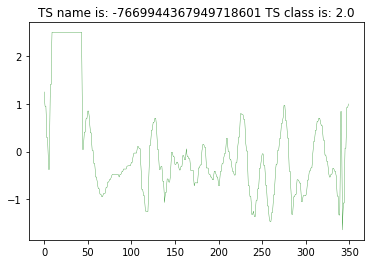

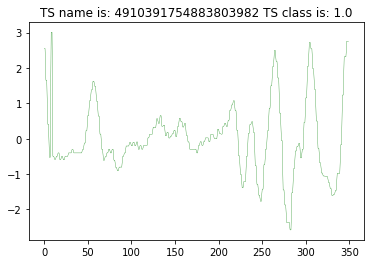

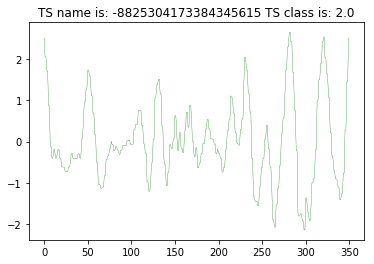

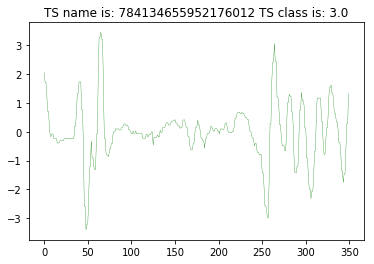

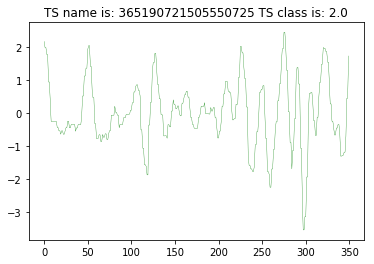

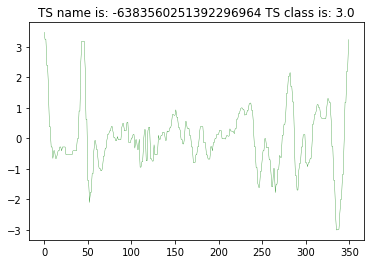

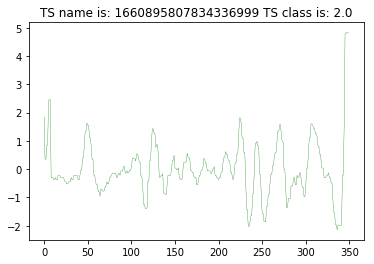

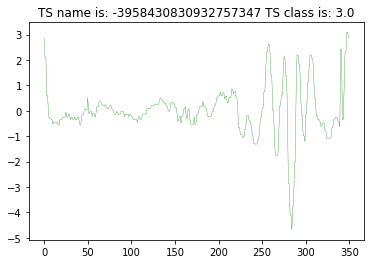

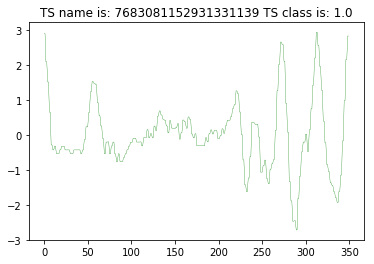

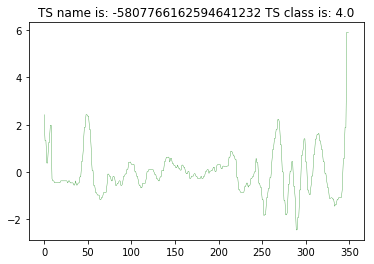

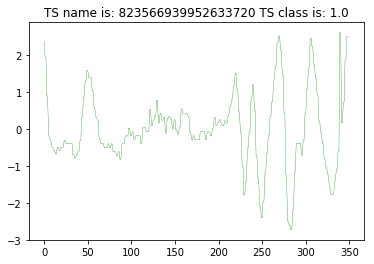

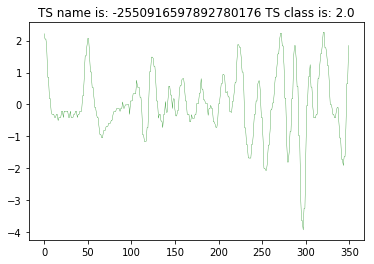

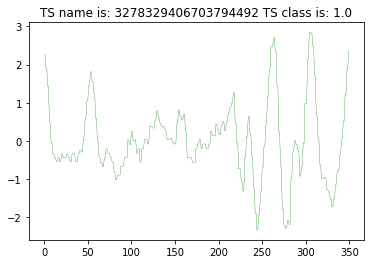

In [27]:
import os
class TimeSeries(object):
    def __init__(self):
        self.class_timeseries = ''
        self.dimension_name = ''
        self.timeseries = None
        self.matched = False
        self.name = ''
        
def load(directory, option):
    dirname = ""
    extension =""
    if option.lower() == "dataset":
        dirname = "/Dataset/"
        extension = ".csv"

    files_list = [f for f in os.listdir(directory + dirname) if f.lower().endswith(extension)]
    list_objects = []
    for file in files_list:
        path = directory + dirname + file
        #an_object = np.genfromtxt(path)
        an_object = np.genfromtxt(path, delimiter = ",")
        list_objects.extend(an_object)
    # return a list[Array_TimeSeries]
    return list_objects
    
def generate_timeseries(directory):
    #list_ts = list[TimeSeries]
    dict_ts = {}
    list_rawData = load(directory, 'Dataset')
    for d in list_rawData:
        # d[0] is the class of TS in the original data, d[1:] is the data in TS
        t = TimeSeries()
        t.class_timeseries = d[0]
        t.timeseries = d[1:]
        t.name = hash(d[1:].tostring())
        dict_ts.update({t.name:t})
    return dict_ts

dict_ts = generate_timeseries("/Users/Jingwei/PycharmProjects/use_see_optimization/TestDataset")
name_list = dict_ts.keys()

for name in name_list:
    ts_data = dict_ts[name].timeseries
    ts_class = dict_ts[name].class_timeseries
    nbr_point = len(ts_data)
    X = range(0, nbr_point)
    
    plt.figure()
    plt.title("TS name is: " + str(name) + " TS class is: " + str(ts_class))
    plt.plot(X, ts_data[0:nbr_point], color='green', linewidth=0.3)

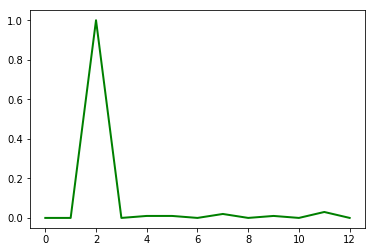

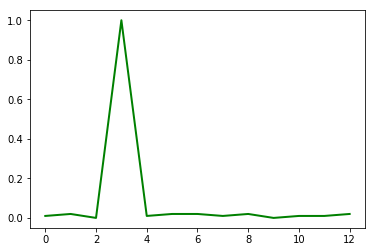

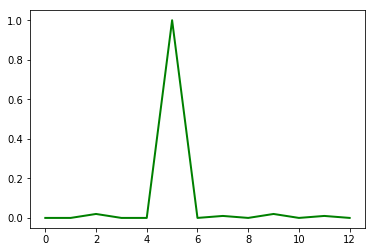

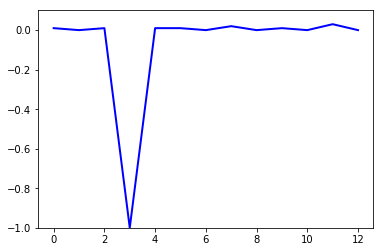

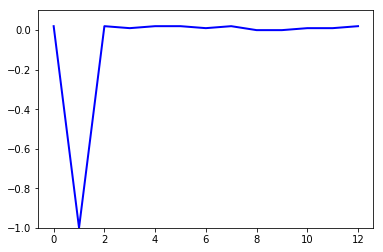

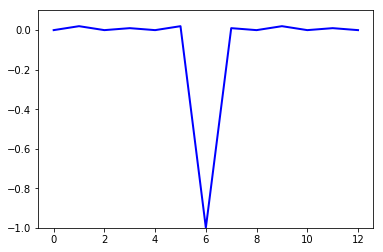

In [19]:
import numpy as np
from matplotlib import pyplot as plt
data1 = np.array([0,0,1,0,0.01,0.01,0,0.02,0,0.01,0,0.03,0])
data2 = np.array([0.01,0.02,0,1,0.01,0.02,0.02,0.01,0.02,0,0.01, 0.01,0.02])
data3 = np.array([0,0,0.02,0,0,1,0,0.01,0,0.02,0,0.01,0])

data4 = np.array([0.01,0,0.01,-1,0.01,0.01,0,0.02,0,0.01,0,0.03,0])
data5 = np.array([0.02,-1,0.02,0.01,0.02,0.02,0.01,0.02,0,0,0.01, 0.01,0.02])
data6 = np.array([0,0.02,0,0.01,0,0.02,-1,0.01,0,0.02,0,0.01,0])

X = range(0, len(data1))

plt.figure()
plt.plot(X, data1, color='green', linewidth=2)
plt.savefig("/Users/Jingwei/Desktop/class1_1.png")
plt.figure()
plt.plot(X, data2, color='green', linewidth=2)
plt.savefig("/Users/Jingwei/Desktop/class1_2.png")
plt.figure()
plt.plot(X, data3, color='green', linewidth=2)
plt.savefig("/Users/Jingwei/Desktop/class1_3.png")


plt.figure()
plt.ylim(-1,0.1)
plt.plot(X, data4, color='blue', linewidth=2)
plt.savefig("/Users/Jingwei/Desktop/class2_1.png")
plt.figure()
plt.ylim(-1,0.1)
plt.plot(X, data5, color='blue', linewidth=2)
plt.savefig("/Users/Jingwei/Desktop/class2_2.png")
plt.figure()
plt.ylim(-1,0.1)
plt.plot(X, data6, color='blue', linewidth=2)
plt.savefig("/Users/Jingwei/Desktop/class2_3.png")

In [67]:
a = np.array([1,2,3,4,5,6])
b = np.array([0])
print(np.concatenate([[0], a]))
print(data1[:2])

[0 1 2 3 4 5 6]
[1, 2]


In [55]:
np.cumsum(data1)

array([ 1,  3,  6, 10, 15, 21])